<a href="https://colab.research.google.com/github/marreapato/Deep_Learning_Course/blob/main/Reading_MIT_Indoor_Scene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Fundamentals_Deep_Learning

!ls




/content/gdrive/MyDrive/Fundamentals_Deep_Learning
 001_tensorflow.ipynb		     06_headline_generator.ipynb
 00_jupyterlab.ipynb		     activities.csv
 01_mnist.ipynb			     asl_model
 02_asl.ipynb			     BANKEX.csv
 03_asl_cnn.ipynb		    'Cópia de 01_mnist.ipynb'
 04a_asl_augmentation.ipynb	     data
 04b_asl_predictions.ipynb	     images
 05a_doggy_door.ipynb		    'NN FeedForward - CIFAR - 10.ipynb'
 05b_presidential_doggy_door.ipynb   RNN_multi.ipynb


In [3]:
import requests
import os

# Define the URL of the dataset
url = "http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar"

# Define the directory where you want to save the dataset
save_dir = "/content/gdrive/MyDrive/Fundamentals_Deep_Learning/mit_indoor_scene_dataset"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define the path where you want to save the downloaded file
save_path = os.path.join(save_dir, "indoorCVPR_09.tar.gz")

# Send an HTTP GET request to download the dataset
response = requests.get(url, stream=True)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Open the file in binary write mode and write the content of the response
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)

    print(f"Downloaded the dataset to {save_path}")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")

# You can now extract the contents of the downloaded tar.gz file using Python's tarfile module if needed.


Downloaded the dataset to /content/gdrive/MyDrive/Fundamentals_Deep_Learning/mit_indoor_scene_dataset/indoorCVPR_09.tar.gz


In [4]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For separating train and test sets
from sklearn.model_selection import train_test_split

# For visualizations
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import numpy as np
import pathlib

In [5]:
from PIL import Image
import os
import tarfile
import os

# Define the path to an example image
image_path = "/content/gdrive/MyDrive/Fundamentals_Deep_Learning/mit_indoor_scene_dataset/indoorCVPR_09.tar.gz"



t = tarfile.open(image_path, 'r')
for member in t.getmembers():
    if ".jpg" in member.name:
        t.extract(member, "outdir")

print(os.listdir('outdir'))

['Images']


Reading Data


In [7]:
import torch
from torchvision import transforms, datasets

# Define the data transformation pipeline
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),     # Resize the image to (224, 224)
    transforms.ToTensor(),             # Convert image to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        ),
    ])

# Specify the root directory of your dataset
data_dir = '/content/gdrive/MyDrive/Fundamentals_Deep_Learning/outdir/Images'

# Create an instance of the ImageFolder dataset
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=data_dir, transform=data_transform)

dataset_size = len(train_dataset)
indices = list(range(dataset_size))

In [11]:
test_dataset.class_to_idx

{'airport_inside': 0,
 'artstudio': 1,
 'auditorium': 2,
 'bakery': 3,
 'bar': 4,
 'bathroom': 5,
 'bedroom': 6,
 'bookstore': 7,
 'bowling': 8,
 'buffet': 9,
 'casino': 10,
 'children_room': 11,
 'church_inside': 12,
 'classroom': 13,
 'cloister': 14,
 'closet': 15,
 'clothingstore': 16,
 'computerroom': 17,
 'concert_hall': 18,
 'corridor': 19,
 'deli': 20,
 'dentaloffice': 21,
 'dining_room': 22,
 'elevator': 23,
 'fastfood_restaurant': 24,
 'florist': 25,
 'gameroom': 26,
 'garage': 27,
 'greenhouse': 28,
 'grocerystore': 29,
 'gym': 30,
 'hairsalon': 31,
 'hospitalroom': 32,
 'inside_bus': 33,
 'inside_subway': 34,
 'jewelleryshop': 35,
 'kindergarden': 36,
 'kitchen': 37,
 'laboratorywet': 38,
 'laundromat': 39,
 'library': 40,
 'livingroom': 41,
 'lobby': 42,
 'locker_room': 43,
 'mall': 44,
 'meeting_room': 45,
 'movietheater': 46,
 'museum': 47,
 'nursery': 48,
 'office': 49,
 'operating_room': 50,
 'pantry': 51,
 'poolinside': 52,
 'prisoncell': 53,
 'restaurant': 54,
 'resta

In [13]:
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(indices, test_size=0.25)
print(len(train_idx), len(test_idx))

# Create a DataLoader to load data in batches
batch_size = 64

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    #shuffle=True,
    sampler=train_sampler
    )

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    #shuffle=True,
    sampler=test_sampler
    )

# Iterate through the DataLoader
for inputs, labels in train_dataloader:
    print(inputs.shape, labels)
    #print(labels.min(), labels.max())
    break

11709 3904
torch.Size([64, 3, 224, 224]) tensor([22, 40,  7,  3,  6, 38,  9, 46, 31, 30, 53, 54, 32, 19, 48,  7, 19, 19,
         4, 36,  3, 50, 54, 57, 41, 12,  6, 47, 20,  0, 17, 43,  8, 43, 19,  4,
        10, 54, 65, 21, 46, 48, 23, 60,  6,  3, 41, 64,  6,  1, 65, 28,  3, 41,
        66, 10, 11, 22, 65,  3, 62, 52, 14,  6])


In [41]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set the path to your dataset directory
dataset_dir = '/content/gdrive/MyDrive/Fundamentals_Deep_Learning/outdir/Images'

# Create an instance of the ImageFolder dataset
dataset = ImageFolder(root=dataset_dir, transform=transform)

# Define the percentage of data to use for testing
test_split = 0.25  # 25% for testing

# Calculate the size of the testing set
test_size = int(test_split * len(dataset))
train_size = len(dataset) - test_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the number of samples in the training and testing sets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# You can now use train_dataloader and test_dataloader to iterate through your data in batches for training and testing.
# Your training and evaluation code goes here.


Number of training samples: 11710
Number of testing samples: 3903


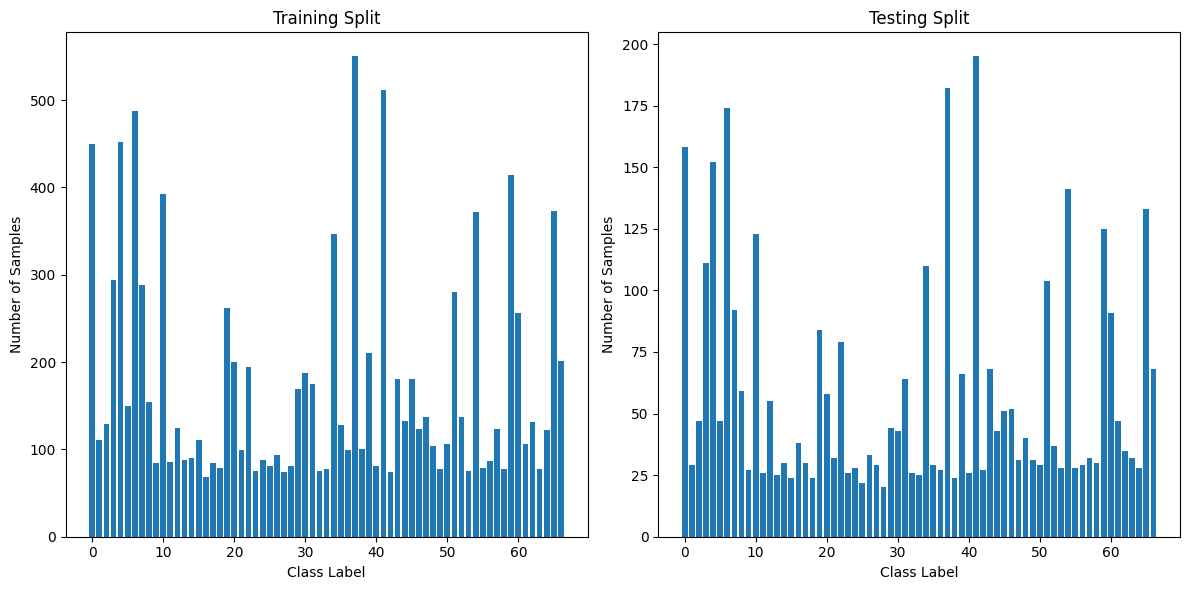

In [42]:
def count_samples_per_class(dataset):
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

train_class_counts = count_samples_per_class(train_dataset)
test_class_counts = count_samples_per_class(test_dataset)

# Extract class labels and counts
train_labels, train_counts = zip(*train_class_counts.items())
test_labels, test_counts = zip(*test_class_counts.items())

# Create bar plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(train_labels, train_counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Training Split')

plt.subplot(1, 2, 2)
plt.bar(test_labels, test_counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Testing Split')

plt.tight_layout()
plt.show()